In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions

In [3]:
FILE_F_MAP = "../data/F_REFERENCE.txt"
#FILE_PS = "../data/WideA_ZA_pk.dat"
FILE_PS = "file_pk.txt"
FILE_BACKGROUND = "../data/WideA_ZA_background.dat"
#FILE_IS = "tab_xi.txt"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70,
    N = 1024, fit_min = 0.05, fit_max= 0.5, con=true)

cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP; expand=false)

GaPSE.parameters_used(stdout, cosmo)


I take the input power spectrum as it is,without expanding.
# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "file_pk.txt"
# F window function input file : "../data/F_REFERENCE.txt"
# CLASS Background input file: "../data/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.19200014818588 Mpc/h_0
# 	 comoving s_max = 571.7022420258767 Mpc/h_0
# 	 comoving s_eff = 435.3747095691862 Mpc/h_0
# 	 comoving z_eff = 0.15045636096027523 
# 	 Volume of the survey V_survey = 3.845366167993746e8
# 	 σ_0 = 15.593462966741178
# 	 σ_1 = 15.074895881392285
# 	 σ_2 = 100.85852368830221
# 	 σ_3 = 3735.1227501923527
# 


In [4]:
GaPSE.print_map_ξ_multipole(cosmo,
    "AutoCorrelationTests/xi_integratedgp_L0.txt",
    "auto_integratedgp"; use_windows = false,
    N_χs = 50, enhancer = 1e10, use_my = false, μ_rtol=1e-3, μ_atol=1e-8)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


I will use quadgk.

time needed for map_integral_on_mu for auto_integratedgp [in s] = 3.34436 


In [5]:
tab_pk = readdlm("file_pk.txt", comments=true);
ks = convert(Vector{Float64}, tab_pk[:,1]);
k_min, k_max = ks[begin], ks[end]
pks = convert(Vector{Float64}, tab_pk[:,2]);
PK = Spline1D(ks, pks);

In [6]:
table = readdlm("AutoCorrelationTests/xi_integratedgp_L0.txt", comments=true)
ss = convert(Vector{Float64}, table[:, 1]);
my_igps = convert(Vector{Float64}, table[:, 2]);

In [7]:
mattia_table = readdlm("/Users/matteofoglieni/Dropbox/GR_effects/Mattia_Output/Monopoles_without_window/xi_integrated_L0.txt")
mattia_ss = convert(Vector{Float64}, mattia_table[2:end, 1]);
mattia_igp = convert(Vector{Float64}, mattia_table[2:end, 2]);

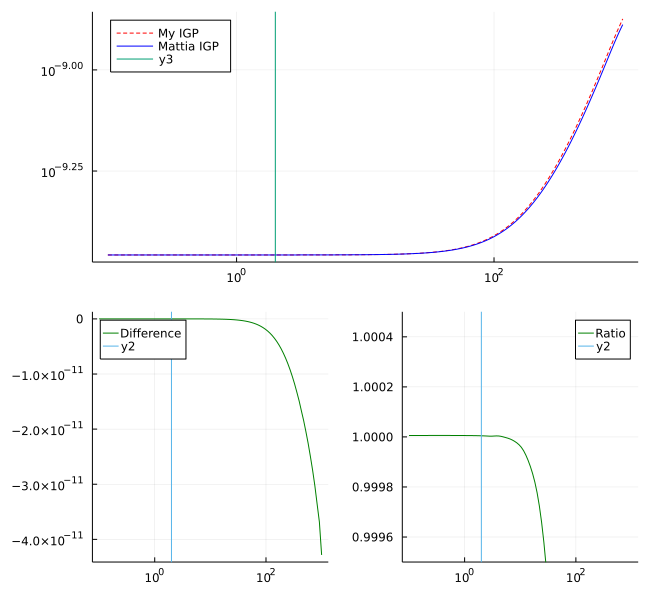

In [25]:
my_xs = ss
my_ys = -my_igps * 1.05718
xs = mattia_ss
ys = -mattia_igp
spline = Spline1D(xs, ys)

S_VLIM = 2

p1 = plot([my_xs, xs], [my_ys,  ys], xaxis=:log, yaxis=:log, lc=[:red :blue], 
    label=["My IGP" "Mattia IGP"], ls=[:dash :solid], legend=:topleft)
vline!(p1, [S_VLIM])

p2 = plot(my_xs, spline.(my_xs) .- my_ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:topleft)
vline!(p2, [S_VLIM])

p3 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, 
    xaxis=:log,
    #ylim=(1.05715, 1.05725)
    ylim=(0.9995, 1.0005)
)
vline!(p3, [S_VLIM])

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )


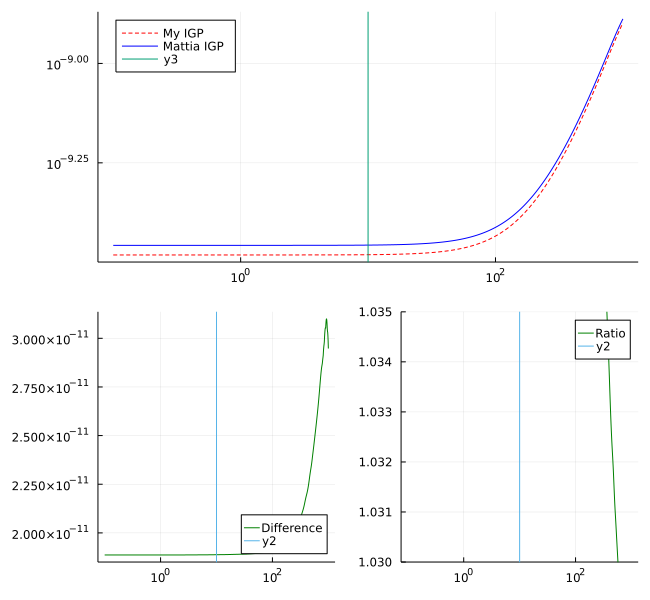

In [9]:
xs = mattia_ss
ys = -mattia_igp
my_xs = xs
my_ys = [-GaPSE.ξ_multipole(cosmo.s_eff, s, "auto_integratedgp", cosmo; use_windows = false)[1] for s in xs]
spline = Spline1D(xs, ys)

S_VLIM = 10

p1 = plot([my_xs, xs], [my_ys,  ys], xaxis=:log, yaxis=:log, lc=[:red :blue], 
    label=["My IGP" "Mattia IGP"], ls=[:dash :solid], legend=:topleft)
vline!(p1, [S_VLIM])

p2 = plot(my_xs, spline.(my_xs) .- my_ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
vline!(p2, [S_VLIM])

p3 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, xaxis=:log,
    ylim=(1.030, 1.035))
vline!(p3, [S_VLIM])

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

In [10]:
tab_mattia_I04_tildes = readdlm("/Users/matteofoglieni/Dropbox/GR_effects/Mattia_Output/I40_tilde.txt");
mattia_I04_ss = convert(Vector{Float64}, tab_mattia_I04_tildes[2:end,1]);
mattia_I04_tildes = convert(Vector{Float64}, tab_mattia_I04_tildes[2:end,2]);
my_I04_tildes = cosmo.tools.I04_tilde.(mattia_I04_ss);

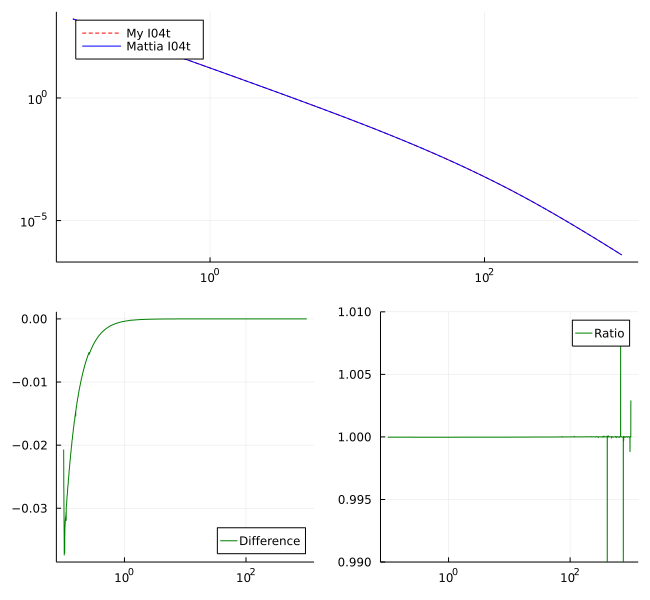

In [11]:
xs = mattia_I04_ss
ys = -mattia_I04_tildes
#spline = cosmo.tools.I04_tilde
my_ys = -cosmo.tools.I04_tilde.(xs) 

p1 = plot([xs, xs], [my_ys,  ys], xaxis=:log, yaxis=:log, lc=[:red :blue], 
    label=["My I04t" "Mattia I04t"], ls=[:dash :solid], legend=:topleft)

p2 = plot(xs, my_ys .- ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(xs, my_ys ./ ys, label="Ratio", lc=:green, xaxis=:log, ylim=(0.99, 1.01))

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )
